# ML and Deep Learning Models

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [223]:
# Sklearn pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD

from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
df_train_sample = pd.read_csv('data/df_train_sample.csv')
df_train_sample.head()


,TransactionID,isFraud,D13,D14,D12,id_04,id_03,D6,D9,D8,...,id_28,id_38,id_35,id_37,id_15,id_36,card4,card6,ProductCD,id_12
0,2987071.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,None,None,None,None,None,None,visa,debit,W,None
1,2988706.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.583333,5.583333,...,Found,T,T,T,Found,F,visa,credit,H,Found
2,2988937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,None,None,None,None,None,None,mastercard,debit,W,None
3,2988966.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,None,None,None,None,None,None,visa,debit,W,None
4,2988970.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,None,None,None,None,None,None,visa,credit,W,None


In [3]:
X_train = df_train_sample.drop(['TransactionID', 'isFraud'], axis=1)
y_train = df_train_sample.isFraud

In [8]:
X_train.shape

(34409, 411)

In [112]:
df_test = pd.read_csv('data/df_test.csv')
X_test = df_test.drop(['TransactionID'], axis=1)

X_test.shape

(506691, 411)

In [81]:
df_valid = pd.read_csv('data/df_valid.csv')
df_valid.head()

,isFraud,D13,D14,D12,id_04,id_03,D6,D9,D8,id_09,...,id_28,id_38,id_35,id_37,id_15,id_36,card4,card6,ProductCD,id_12
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,visa,debit,W,None
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,visa,debit,C,None
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.0,0.0,...,Found,T,T,T,Found,F,american express,credit,H,NotFound
3,0.0,0.0,0.0,163.0,0.0,0.0,163.0,0.0,0.0,0.0,...,None,None,None,None,None,None,visa,credit,C,None
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,None,None,None,None,None,None,mastercard,debit,W,None


In [82]:
X_valid = df_valid.drop(['isFraud'], axis=1)
y_valid = df_valid.isFraud
y_true = y_valid

X_valid.shape

(118003, 412)

In [85]:
# PCC
class_0 = df_valid.isFraud.value_counts()[0]
class_1 = df_valid.isFraud.value_counts()[1]
total = class_0 + class_1

class_0**2 / total ** 2 + class_1 ** 2 / total ** 2

0.9310656812782293

In [5]:
categorical_features = ['id_33', 'id_30', 'id_34', 'DeviceInfo', 'id_16', 
       'P_emaildomain', 'R_emaildomain', 'id_31', 'DeviceType', 
       'id_29', 'id_28', 'id_38', 'id_35', 'id_37', 'id_15',
      'id_36', 'card4', 'card6', 'ProductCD', 'id_12'] 
numeric_features = [c for c in df_train_sample.columns if c not in categorical_features and c not in ['TransactionID', 'isFraud']]


In [216]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

pca = Pipeline(steps=[
    ('pca', TruncatedSVD(n_components=200))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [217]:
# define transformer pipelines
preprocess_no_pca = Pipeline(steps=[('preprocessor', preprocessor)])
preprocess_pca = Pipeline(steps=[('preprocessor', preprocessor),
                                ('pca', pca)])

In [218]:
# check variance explained PCA
X_train_pca = preprocess_pca.fit(X_train)

Text(0.5, 1.0, 'Proportion variance explained to number of components')

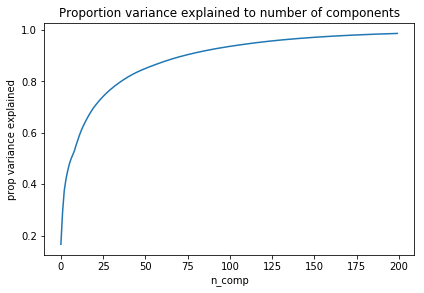

In [219]:
ratios = X_train_pca.steps[-1][-1][-1].explained_variance_ratio_
ratios_cum = np.cumsum(ratios)
plt.plot(ratios_cum)
plt.xlabel('n_comp')
plt.ylabel('prop variance explained')
plt.tight_layout()
plt.title('Proportion variance explained to number of components')

In [220]:
# variance explained 95%
[i for i in range(len(ratios_cum)) if ratios_cum[i] > 0.95][0]

115

In [221]:
pca = Pipeline(steps=[
    ('pca', TruncatedSVD(n_components=115))])

preprocess_pca = Pipeline(steps=[('preprocessor', preprocessor),
                                ('pca', pca)])

In [222]:
# shape with and without PCA
shape_no_pca = preprocess_no_pca.fit_transform(X_train).shape
shape_w_pca = preprocess_pca.fit_transform(X_train).shape
print(shape_no_pca)
print(shape_w_pca)

(34409, 1394)
(34409, 115)


## GBT

In [224]:
from sklearn.ensemble import GradientBoostingClassifier

In [231]:
model_no_pca_gbt = GradientBoostingClassifier()
model_pca_gbt = GradientBoostingClassifier()

In [234]:
model_no_pca_gbt.fit(preprocess_no_pca.fit_transform(X_train), y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [235]:
model_pca_gbt.fit(preprocess_pca.fit_transform(X_train), y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [237]:
## save models
filename = 'models/model_no_pca_gbt.sav'
pickle.dump(model_no_pca_gbt, open(filename, 'wb'))

filename = 'models/model_pca_gbt.sav'
pickle.dump(model_pca_gbt, open(filename, 'wb'))

## Validation

### No PCA

In [379]:
y_true = y_valid
y_pred_proba = model_no_pca_gbt.predict_proba(preprocess_no_pca.transform(X_valid))
y_pred_proba = pd.DataFrame(y_pred_proba).apply(lambda x: 1-x).loc[:, 0]

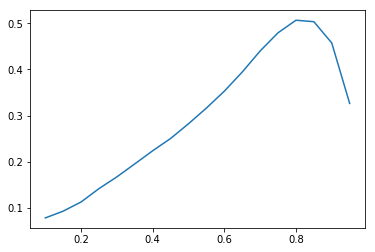

In [380]:
# get best threshold value that maximizes F1 score

f1_scores = []
thresholds = np.arange(0.1, 1., 0.05)

for thresh in thresholds:
    y_pred_temp = y_pred_proba.apply(lambda x: 1 if x > thresh else 0)
    f1score = f1_score(y_true, y_pred_temp)
    f1_scores.append(f1score)
    
plt.plot(thresholds, f1_scores)    
    

In [381]:
# best thresh
ind = np.argsort(f1_scores)[-1]
best_thresh = thresholds[ind]
best_thresh

0.8000000000000002

In [382]:
# y_pred = y_pred_proba.apply(lambda x: 1 if x > best_thresh else 0)
y_pred = y_pred_proba.apply(lambda x: 1 if x > 0.5 else 0)

In [383]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Precision = 0.17233998120497024
Recall = 0.7825983878615458
F1 Score = 0.2824747561184323


In [384]:
def plot_confusion_matrix(y_true, y_pred, classes, title, Norm,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if Norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

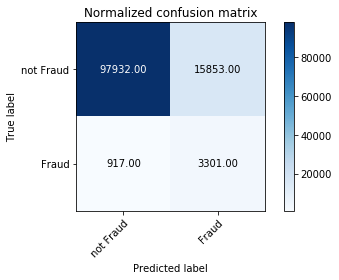

In [385]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

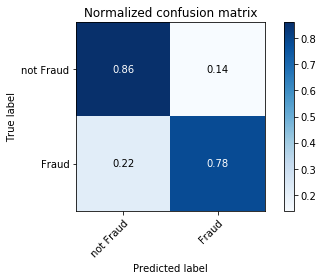

In [386]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

In [387]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

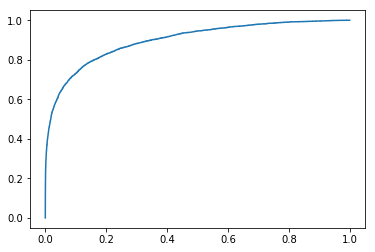

In [388]:
plt.plot(fpr, tpr)

In [389]:
auc(fpr, tpr)

0.8983674685895865

#### Test Prediction

In [425]:
y_pred_proba = model_no_pca_gbt.predict(preprocess_no_pca.transform(X_test))
y_pred_proba = pd.DataFrame(y_pred_proba).apply(lambda x: 1-x).loc[:, 0]

In [426]:
df_preds = pd.DataFrame(df_test.TransactionID)
df_preds = pd.concat([df_preds, y_pred_proba], axis=1)

In [427]:
df_preds.columns = ['TransactionID', 'isFraud']
df_preds.TransactionID = df_preds.TransactionID.astype('int') 
df_preds.shape

(506691, 2)

In [428]:
df_preds.head()

,TransactionID,isFraud
0,3664355,1.0
1,3664418,1.0
2,3664423,1.0
3,3664469,1.0
4,3665115,1.0


In [429]:
df_preds.to_csv('predicted_no_pca_gbt.csv', index=False)

### With PCA

In [390]:
y_true = y_valid
y_pred_proba = model_pca_gbt.predict_proba(preprocess_pca.transform(X_valid))
y_pred_proba = pd.DataFrame(y_pred_proba).apply(lambda x: 1-x).loc[:, 0]

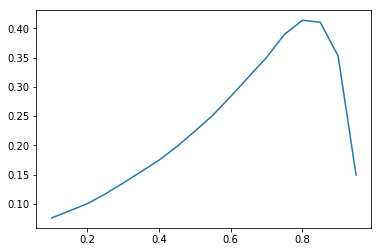

In [391]:
# get best threshold value that maximizes F1 score

f1_scores = []
thresholds = np.arange(0.1, 1., 0.05)

for thresh in thresholds:
    y_pred_temp = y_pred_proba.apply(lambda x: 1 if x > thresh else 0)
    f1score = f1_score(y_true, y_pred_temp)
    f1_scores.append(f1score)
    
plt.plot(thresholds, f1_scores)    
    

In [392]:
# best thresh
ind = np.argsort(f1_scores)[-1]
best_thresh = thresholds[ind]
best_thresh

0.8000000000000002

In [393]:
# y_pred = y_pred_proba.apply(lambda x: 1 if x > best_thresh else 0)
y_pred = y_pred_proba.apply(lambda x: 1 if x > 0.5 else 0)

In [394]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Precision = 0.1316630024474219
Recall = 0.7524893314366998
F1 Score = 0.22411297440423653


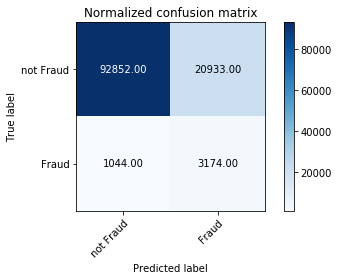

In [395]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

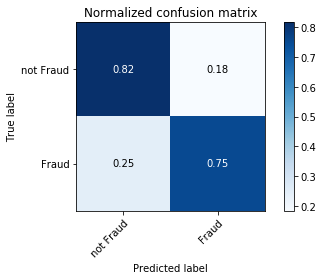

In [396]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

In [397]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

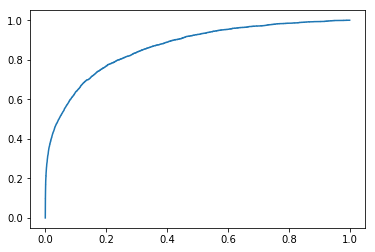

In [398]:
plt.plot(fpr, tpr)

In [399]:
auc(fpr, tpr)

0.8653136557506064

#### Test Prediction

In [420]:
y_pred_proba = model_pca_gbt.predict(preprocess_pca.transform(X_test))
y_pred_proba = pd.DataFrame(y_pred_proba).apply(lambda x: 1-x).loc[:, 0]

In [421]:
df_preds = pd.DataFrame(df_test.TransactionID)
df_preds = pd.concat([df_preds, y_pred_proba], axis=1)

In [422]:
df_preds.columns = ['TransactionID', 'isFraud']
df_preds.TransactionID = df_preds.TransactionID.astype('int') 
df_preds.shape

(506691, 2)

In [423]:
df_preds.head()

,TransactionID,isFraud
0,3664355,1.0
1,3664418,1.0
2,3664423,1.0
3,3664469,1.0
4,3665115,0.0


In [424]:
df_preds.to_csv('predicted_pca_gbt.csv', index=False)

## Deep Learning

In [317]:
input_dim_no_pca = shape_no_pca[1]
input_dim_pca = shape_w_pca[1]

In [318]:
# custom AUC ROC metric
def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

In [319]:
# Keras model definition

def classifier(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.1))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))
    
    # Build Model...
    model.compile(loss='binary_crossentropy', optimizer='adam',metrics=[auroc])
    
    return model

In [323]:
clf = classifier(input_dim=input_dim_no_pca)
clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 256)               357120    
_________________________________________________________________
dropout_31 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 2)                 514       
Total params: 423,426
Trainable params: 423,426
Non-trainable params: 0
_________________________________________________________________


In [324]:
# no PCA pipeline
model_no_pca = classifier(input_dim=input_dim_no_pca)
model_no_pca.fit(preprocess_no_pca.fit_transform(X_train),\
                                           pd.get_dummies(y_train), epochs=50)

Epoch 1/50
34409/34409 [==============================] - 11s 321us/step - loss: 0.4814 - auroc: 0.8510
Epoch 2/50
34409/34409 [==============================] - 9s 270us/step - loss: 0.4319 - auroc: 0.8798
Epoch 3/50
34409/34409 [==============================] - 9s 271us/step - loss: 0.4085 - auroc: 0.8917
Epoch 4/50
34409/34409 [==============================] - 9s 272us/step - loss: 0.3922 - auroc: 0.9006
Epoch 5/50
34409/34409 [==============================] - 10s 297us/step - loss: 0.3732 - auroc: 0.9093
Epoch 6/50
34409/34409 [==============================] - 9s 270us/step - loss: 0.3592 - auroc: 0.9169
Epoch 7/50
34409/34409 [==============================] - 9s 272us/step - loss: 0.3440 - auroc: 0.9233
Epoch 8/50
34409/34409 [==============================] - 9s 271us/step - loss: 0.3290 - auroc: 0.9300
Epoch 9/50
34409/34409 [==============================] - 9s 273us/step - loss: 0.3153 - auroc: 0.9346
Epoch 10/50
34409/34409 [==============================] - 9s 271us/ste

In [326]:
# with PCA pipeline
model_pca = classifier(input_dim=input_dim_pca)
model_pca.fit(preprocess_pca.fit_transform(X_train),\
              pd.get_dummies(y_train), epochs=50)

Epoch 1/50
34409/34409 [==============================] - 11s 317us/step - loss: 0.4919 - auroc: 0.8446
Epoch 2/50
34409/34409 [==============================] - 8s 230us/step - loss: 0.4427 - auroc: 0.8724
Epoch 3/50
34409/34409 [==============================] - 8s 234us/step - loss: 0.4206 - auroc: 0.8855
Epoch 4/50
34409/34409 [==============================] - 8s 233us/step - loss: 0.3999 - auroc: 0.8942
Epoch 5/50
34409/34409 [==============================] - 8s 234us/step - loss: 0.3841 - auroc: 0.9036
Epoch 6/50
34409/34409 [==============================] - 8s 234us/step - loss: 0.3677 - auroc: 0.9128
Epoch 7/50
34409/34409 [==============================] - 8s 233us/step - loss: 0.3521 - auroc: 0.9206
Epoch 8/50
34409/34409 [==============================] - 8s 229us/step - loss: 0.3406 - auroc: 0.9256
Epoch 9/50
34409/34409 [==============================] - 8s 235us/step - loss: 0.3238 - auroc: 0.9328
Epoch 10/50
34409/34409 [==============================] - 8s 232us/step

In [327]:
# save models
model_no_pca.save('models/model_no_pca.h5')
model_pca.save('models/model_pca.h5')

## Validation

### No PCA

In [400]:
y_pred_proba = model_no_pca.predict(preprocess_no_pca.transform(X_valid))
y_pred_proba = pd.DataFrame(y_pred_proba).loc[:, 1]

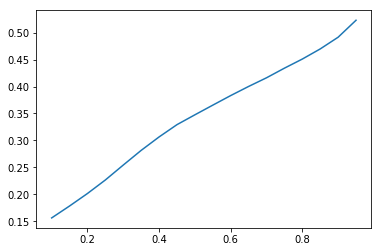

In [401]:
# get best threshold value that maximizes F1 score

f1_scores = []
thresholds = np.arange(0.1, 1., 0.05)

for thresh in thresholds:
    y_pred_temp = y_pred_proba.apply(lambda x: 1 if x > thresh else 0)
    f1score = f1_score(y_true, y_pred_temp)
    f1_scores.append(f1score)
    
plt.plot(thresholds, f1_scores)    
    

In [402]:
# best thresh
ind = np.argsort(f1_scores)[-1]
best_thresh = thresholds[ind]
best_thresh

0.9500000000000003

In [403]:
# y_pred = y_pred_proba.apply(lambda x: 1 if x > best_thresh else 0)
y_pred = y_pred_proba.apply(lambda x: 1 if x > 0.5 else 0)

In [404]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Precision = 0.21454788121454788
Recall = 0.914651493598862
F1 Score = 0.3475675675675675


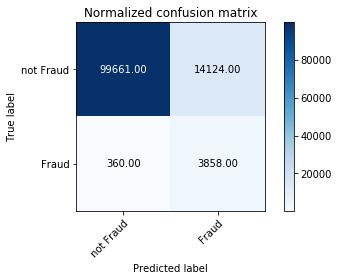

In [405]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

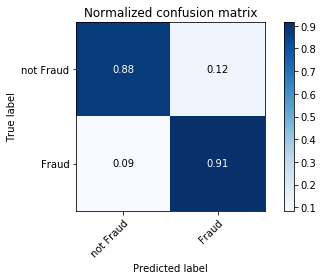

In [406]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

In [407]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

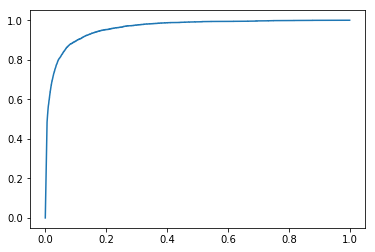

In [408]:
plt.plot(fpr, tpr)

In [409]:
auc(fpr, tpr)

0.9610817053191061

#### Test Prediction

In [340]:
y_pred_proba = model_no_pca.predict(preprocess_no_pca.transform(X_test))
y_pred_proba = pd.DataFrame(y_pred_proba).loc[:, 1]

In [341]:
df_preds = pd.DataFrame(df_test.TransactionID)
df_preds = pd.concat([df_preds, y_pred_proba], axis=1)

In [342]:
df_preds.columns = ['TransactionID', 'isFraud']
df_preds.TransactionID = df_preds.TransactionID.astype('int') 
df_preds.shape

(506691, 2)

In [343]:
df_preds.head()

,TransactionID,isFraud
0,3664355,0.000042
1,3664418,0.000705
2,3664423,0.190787
3,3664469,0.041309
4,3665115,0.115690


In [344]:
df_preds.to_csv('predicted_no_pca_dl.csv', index=False)

### With PCA

In [410]:
y_pred_proba = model_pca.predict(preprocess_pca.transform(X_valid))
y_pred_proba = pd.DataFrame(y_pred_proba).loc[:, 1]

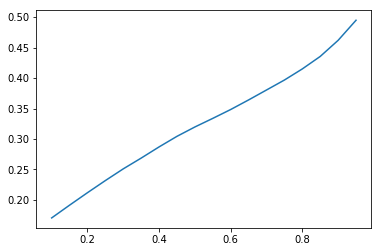

In [411]:
# get best threshold value that maximizes F1 score

f1_scores = []
thresholds = np.arange(0.1, 1., 0.05)

for thresh in thresholds:
    y_pred_temp = y_pred_proba.apply(lambda x: 1 if x > thresh else 0)
    f1score = f1_score(y_true, y_pred_temp)
    f1_scores.append(f1score)
    
plt.plot(thresholds, f1_scores)    
    

In [412]:
# best thresh
ind = np.argsort(f1_scores)[-1]
best_thresh = thresholds[ind]
best_thresh

0.9500000000000003

In [413]:
# y_pred = y_pred_proba.apply(lambda x: 1 if x > best_thresh else 0)
y_pred = y_pred_proba.apply(lambda x: 1 if x > 0.5 else 0)

In [414]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1Score = f1_score(y_true, y_pred)

      
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

Summary Stats
Precision = 0.19323527955232012
Recall = 0.9250829777145566
F1 Score = 0.31969194215722424


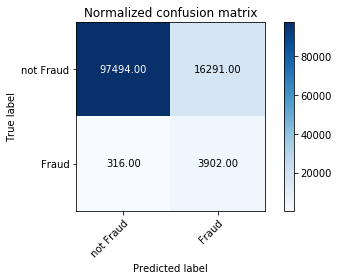

In [415]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=False,
                      title='Normalized confusion matrix')

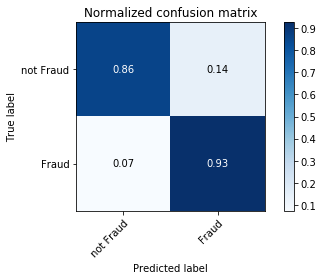

In [416]:
np.set_printoptions(precision=2)
class_names = ['not Fraud', 'Fraud']
plot_confusion_matrix(y_true, y_pred, classes=class_names, Norm=True,
                      title='Normalized confusion matrix')

In [417]:
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

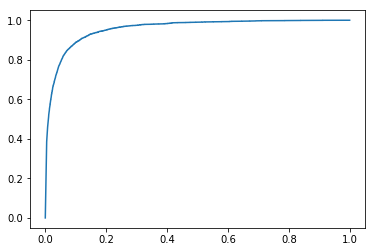

In [418]:
plt.plot(fpr, tpr)

In [419]:
auc(fpr, tpr)

0.9570707905714139

#### Test Prediction

In [355]:
y_pred_proba = model_pca.predict(preprocess_pca.transform(X_test))
y_pred_proba = pd.DataFrame(y_pred_proba).loc[:, 1]

In [356]:
df_preds = pd.DataFrame(df_test.TransactionID)
df_preds = pd.concat([df_preds, y_pred_proba], axis=1)

In [357]:
df_preds.columns = ['TransactionID', 'isFraud']
df_preds.TransactionID = df_preds.TransactionID.astype('int') 
df_preds.shape

(506691, 2)

In [358]:
df_preds.head()

,TransactionID,isFraud
0,3664355,0.002851
1,3664418,0.000064
2,3664423,0.021852
3,3664469,0.004446
4,3665115,0.001305


In [359]:
df_preds.to_csv('predicted_pca_dl.csv', index=False)